In [32]:
#Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, precision_score

In [33]:
#Load the dataset
df = pd.read_csv('covid_symptoms.csv')

In [34]:
#Drop missing values
df = df.dropna()

In [35]:
#Define the symptoms
symptom_cols = ['Fever', 'Tiredness', 'Dry-Cough', 'Difficulty-in-Breathing', 'Sore-Throat',
                'None_Sympton', 'Pains', 'Nasal-Congestion', 'Runny-Nose', 'Diarrhea']

In [36]:
# Add covid_result column (1 = Positive, 0 = Negative)
# 3+ symptoms or Severity_Severe
df['covid_result'] = ((df[symptom_cols].sum(axis=1) >= 3) | (df['Severity_Severe'] == 1)).astype(int)


In [37]:
#Check class balance
print("Class distribution:\n", df['covid_result'].value_counts())

Class distribution:
 covid_result
1    270900
0     45900
Name: count, dtype: int64


In [38]:
#Select features and target
X = df[symptom_cols]
y = df['covid_result']

In [39]:
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [40]:
#Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [41]:
#Train the model with class_weight and depth limit to prevent overfitting
model = RandomForestClassifier(n_estimators=100, max_depth=5, class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, random_state=42)

In [42]:

# 1. Define your Random Forest model (no need to fit it yet)
model = RandomForestClassifier(n_estimators=100, max_depth=5, class_weight='balanced', random_state=42)

# 2. Define the scoring metric you want (e.g., precision)
scorer = make_scorer(precision_score)

# 3. Define the cross-validation method (StratifiedKFold is good for imbalanced data)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. Perform cross-validation on the scaled features (X_train_scaled) and labels (y_train)
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring=scorer)

# 5. Output the results
print(f"Cross-validation Precision Scores: {cv_scores}")
print(f"Mean Precision: {cv_scores.mean():.2f}")


Cross-validation Precision Scores: [1. 1. 1. 1. 1.]
Mean Precision: 1.00


In [43]:
from sklearn.metrics import precision_recall_curve
# Evaluate the model
# Fit the model again (if it was redefined in a previous cell)
model.fit(X_train_scaled, y_train)

# Get predicted probabilities for the positive class
y_probs = model.predict_proba(X_test_scaled)[:, 1]

# Get precision, recall, and thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

#Find the threshold where recall is still high (e.g. >= 0.95)
for p, r, t in zip(precisions, recalls, thresholds):
    if r >= 0.95 and p > 0.8:  # adjust precision requirement as needed
        print(f"Threshold: {t:.2f}, Precision: {p:.2f}, Recall: {r:.2f}")

custom_threshold = 0.58
y_pred_custom = (y_probs >= custom_threshold).astype(int)

# Evaluate
print("Custom Threshold Evaluation")
print("Accuracy:", accuracy_score(y_test, y_pred_custom))
print("Classification Report:\n", classification_report(y_test, y_pred_custom))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_custom))

Threshold: 0.07, Precision: 0.85, Recall: 1.00
Threshold: 0.09, Precision: 0.86, Recall: 1.00
Threshold: 0.09, Precision: 0.86, Recall: 1.00
Threshold: 0.10, Precision: 0.87, Recall: 1.00
Threshold: 0.10, Precision: 0.87, Recall: 0.99
Threshold: 0.11, Precision: 0.87, Recall: 0.99
Threshold: 0.11, Precision: 0.88, Recall: 0.99
Threshold: 0.12, Precision: 0.88, Recall: 0.99
Threshold: 0.12, Precision: 0.88, Recall: 0.99
Threshold: 0.14, Precision: 0.89, Recall: 0.99
Threshold: 0.14, Precision: 0.89, Recall: 0.98
Threshold: 0.14, Precision: 0.89, Recall: 0.98
Threshold: 0.15, Precision: 0.90, Recall: 0.98
Threshold: 0.16, Precision: 0.90, Recall: 0.98
Threshold: 0.16, Precision: 0.91, Recall: 0.98
Threshold: 0.17, Precision: 0.91, Recall: 0.98
Threshold: 0.17, Precision: 0.91, Recall: 0.97
Threshold: 0.17, Precision: 0.92, Recall: 0.97
Threshold: 0.18, Precision: 0.92, Recall: 0.97
Threshold: 0.18, Precision: 0.93, Recall: 0.97
Threshold: 0.19, Precision: 0.93, Recall: 0.97
Threshold: 0.

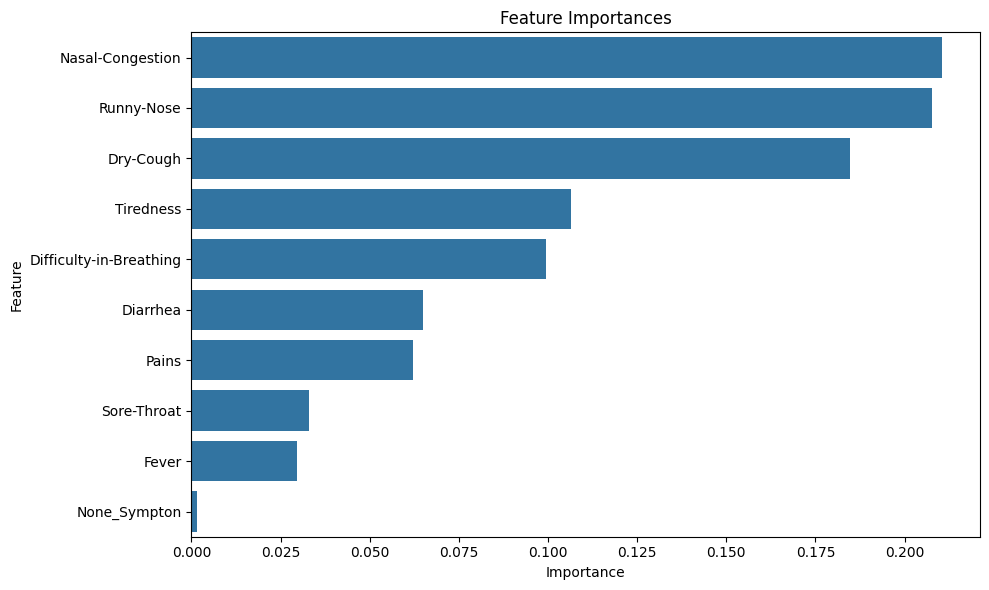

In [44]:
#Feature importance
importances = model.feature_importances_
feature_df = pd.DataFrame({'Feature': symptom_cols, 'Importance': importances}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df)
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

In [ ]:
#Save model and scaler
os.makedirs('ml_models', exist_ok=True)
with open('ml_models/covid_symptom_predictor.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)
with open('ml_models/scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

print("Model and scaler saved successfully.")